In [1]:
# system imports
import os, json, shutil

# data science
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from numpy import random
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from pickle import load

# PyTorch
import torch
from botorch import fit_gpytorch_model
import gpytorch

# plotting 
import moviepy.video.io.ImageSequenceClip
from matplotlib import rcParams
import matplotlib.ticker as plticker
from matplotlib.ticker import FuncFormatter, MultipleLocator
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
from matplotlib import cm
params = {'text.usetex': False, 'mathtext.fontset': 'stix'}
plt.rcParams.update(params)
%matplotlib inline

# import descriptors
from src.descriptors.calculate_descriptors import Descriptors

# Helper Functions

In [2]:
# Define Gaussian Process Model with **kernel**
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        # Use **kernel** for specific application
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# function for training a GP
def train_gp(x, y):

    x = torch.tensor(x)
    y = torch.tensor(y)
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    model = GPModel(x, y, likelihood)
    model.train()
    likelihood.train()
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    fit_gpytorch_model(mll)
    model.eval()
    likelihood.eval()

    return model, likelihood

# function for generating prediction mean and var with GP model
def predict(x, model, likelihood):

    prediction = model(torch.tensor(x))
    mean = prediction.mean.detach().numpy()
    var = prediction.variance.detach().numpy()

    return mean, var

# function for generating objective function with some noise
def true_objective_function(n_pts=400, noise_params=(0, 0.25)):
    x = np.linspace(0, 2 * np.pi, num=n_pts)
    noise = np.random.randint(0, 2, x.size) * np.random.normal(loc=noise_params[0], scale=noise_params[1], size=x.size)
    y = np.sin(np.pi * x + 0.5) - np.sin(np.pi * 0.5 * x + 3) + np.sin(np.pi * x * 2) + np.sin(np.pi * 4 * x - 0.25) + noise

    return x, noise, y

# function for observed data from the true objective function
def observe_data(indices, x, true_obj):

    obs_x = x[indices]
    obs_y = true_obj[indices]

    return obs_x, obs_y

# generate single figure with certain size
def gen_single_figure(size=(20, 9)):

    fig, ax = plt.subplots(figsize=size)
    ax.grid(True, linewidth=1.0, color='0.95')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_axisbelow(True)
    for axis in ['bottom', 'left']:
        ax.spines[axis].set_linewidth(2.5)
    for tick in ax.get_yticklabels():
        tick.set_fontname("Arial")
        tick.set_fontsize(12)
    for tick in ax.get_xticklabels():
        tick.set_fontname("Arial")
        tick.set_fontsize(12)
    
    return fig, ax

# generate n x n subplots with certain size
def gen_subplot_figure(subplots = (2, 2), size=(20, 9)):

    fig, axs = plt.subplots(subplots[0], subplots[1], figsize=size)
    ax1, ax2, ax3, ax4 = axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]
    for ax in [ax1, ax2, ax3, ax4]:
        ax.grid(True, linewidth=1.0, color='0.95')
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.set_axisbelow(True)
        for axis in ['bottom', 'left']:
            ax.spines[axis].set_linewidth(2.5)
        for tick in ax.get_yticklabels():
            tick.set_fontname("Arial")
            tick.set_fontsize(12)
        for tick in ax.get_xticklabels():
            tick.set_fontname("Arial")
            tick.set_fontsize(12)

    return fig, [ax1, ax2, ax3, ax4]

# Generate Objective Function

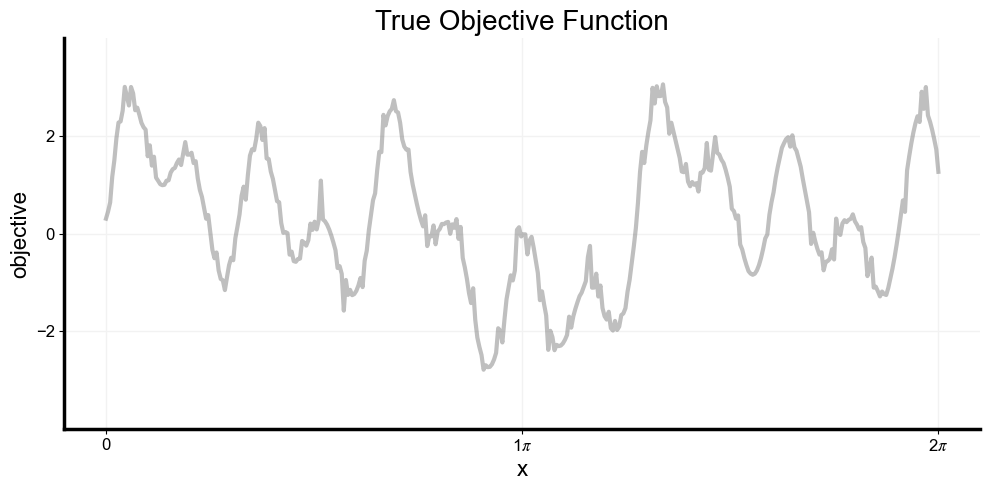

In [3]:
# generate "true" objective function
x, noise, y = true_objective_function(n_pts = 400, noise_params = (0, 0.25))

# get some observed data
r = np.sort(np.random.randint(10, 80, 20))
observed_x, observed_y = observe_data(r, x, y)

# plot settings
fd_large = {"name": "arial", "size": 20}
fd_medium = {"name": "arial", "size": 16}
fig, ax = gen_single_figure(size = (10, 5))

# plot the data
ax.plot(x, y, color = "gray", linewidth = 3.0, alpha = 0.5, label="True objective function", zorder=2)
ax.set_title("True Objective Function", fontdict = fd_large)
ax.set_xlabel("x", fontdict = fd_medium)
ax.set_ylabel("objective", fontdict = fd_medium)
ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: '{:.0f}$\pi$'.format(val / np.pi) if val != 0 else '0'))
ax.xaxis.set_major_locator(MultipleLocator(base=np.pi))

plt.setp(ax, yticks=[-2, 0, 2], ylim=(-4, 4))
plt.tight_layout()
fig.savefig("true_obj.png")

# Perform Single Active Learning Step

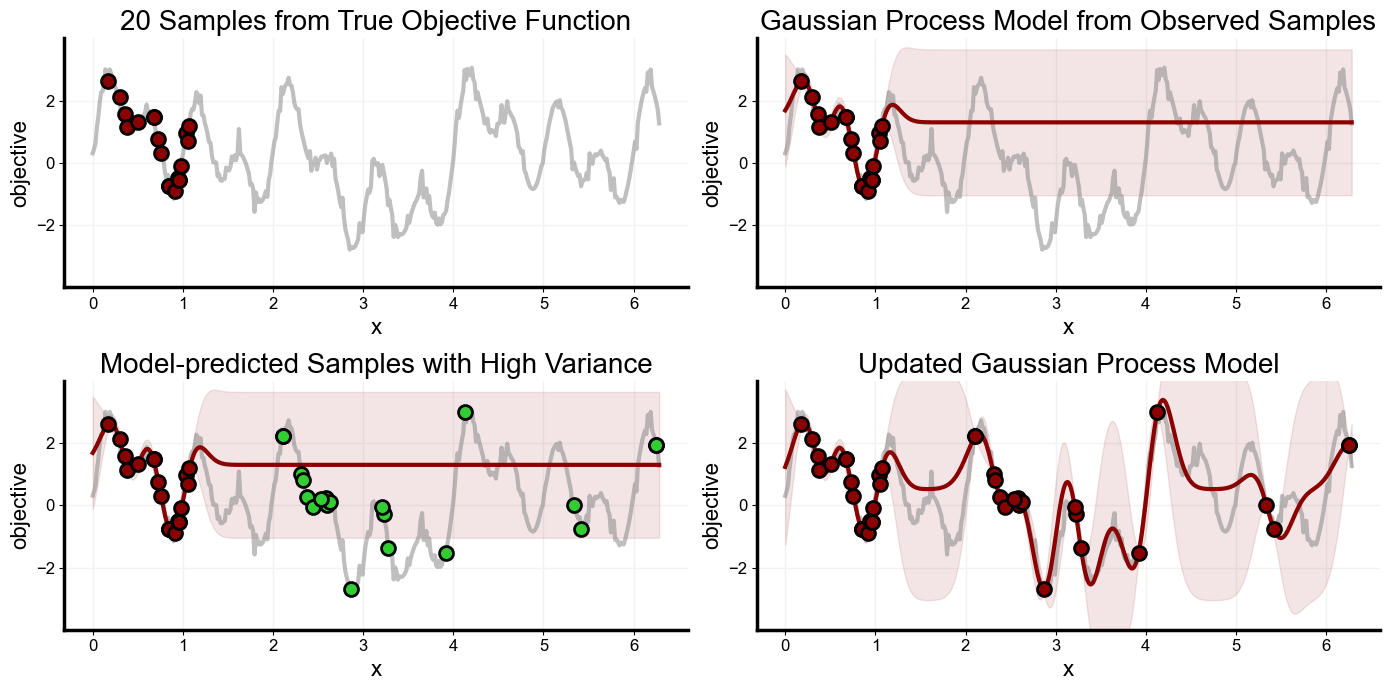

In [4]:
# plot settings
fd_large = {"name": "arial", "size": 20}
fd_medium = {"name": "arial", "size": 16}
fig, axs = gen_subplot_figure(size = (14, 7))
plt.setp(axs, yticks=[-2, 0, 2], ylim=(-4, 4))

# plot ax1 - true objective function with initial samples
ax1 = axs[0]
ax1.plot(x, y, color = "gray", linewidth = 3.0, alpha = 0.5, label="True objective function", zorder=2)
ax1.scatter(observed_x, observed_y, color = "darkred", s = 100, edgecolor = "black", linewidth = 2.0, label="Observed samples", zorder=4)
ax1.set_title("20 Samples from True Objective Function", fontdict = fd_large)
ax1.set_xlabel("x", fontdict = fd_medium)
ax1.set_ylabel("objective", fontdict = fd_medium)

# plot ax2 - GP fit
ax2 = axs[1]
ax2.plot(x, y, color = "gray", linewidth = 3.0, alpha = 0.5, label="True objective function", zorder=2)
ax2.scatter(observed_x, observed_y, color = "darkred", s = 100, edgecolor = "black", linewidth = 2.0, label="Observed samples", zorder=4)
model, likelihood = train_gp(observed_x, observed_y)
pred_mean, pred_var = predict(x, model, likelihood)
ax2.plot(x, pred_mean, color = "darkred", linewidth = 3.0, label="GPR model", zorder=3)
ax2.fill_between(x, pred_mean + 1.96 * np.sqrt(pred_var), pred_mean - 1.96 * np.sqrt(pred_var), color = "darkred", alpha = 0.1, label="GPR model 95% CI", zorder=1)
ax2.set_title("Gaussian Process Model from Observed Samples", fontdict = fd_large)
ax2.set_xlabel("x", fontdict = fd_medium)
ax2.set_ylabel("objective", fontdict = fd_medium)

# plot ax3 - GPR fit with variance
ax3 = axs[2]
ax3.plot(x, y, color = "gray", linewidth = 3.0, alpha = 0.5, label="True objective function", zorder=2)
ax3.scatter(observed_x, observed_y, color = "darkred", s = 100, edgecolor = "black", linewidth = 2.0, label="Observed samples", zorder=4)
model, likelihood = train_gp(observed_x, observed_y)
pred_mean, pred_var = predict(x, model, likelihood)
ax3.plot(x, pred_mean, color = "darkred", linewidth = 3.0, label="GPR model", zorder=3)
ax3.fill_between(x, pred_mean + 1.96 * np.sqrt(pred_var), pred_mean - 1.96 * np.sqrt(pred_var), color = "darkred", alpha = 0.1, label="GPR model 95% CI", zorder=1)
high_var_indices = np.argsort(pred_var)[-190:]
sub_sample = np.random.choice(high_var_indices, size=20)
add_x = x[sub_sample]
add_y = y[sub_sample]
ax3.scatter(add_x, add_y, color = "limegreen", s = 100, edgecolor = "black", linewidth = 2.0, label="Additional samples", zorder=4)
ax3.set_title("Model-predicted Samples with High Variance", fontdict = fd_large)
ax3.set_xlabel("x", fontdict = fd_medium)
ax3.set_ylabel("objective", fontdict = fd_medium)

# plot ax4 - add some suggested samples from the uncertain region
ax4 = axs[3]
ax4.plot(x, y, color = "gray", linewidth = 3.0, alpha = 0.5, label="True objective function", zorder=2)
model, likelihood = train_gp(np.append(observed_x, add_x), np.append(observed_y, add_y))
pred_mean, pred_var = predict(x, model, likelihood)
ax4.scatter(np.append(observed_x, add_x), np.append(observed_y, add_y), color = "darkred", s = 100, edgecolor = "black", linewidth = 2.0, label="Observed samples", zorder=4)
ax4.plot(x, pred_mean, color = "darkred", linewidth = 3.0, label="GPR model", zorder=3)
ax4.fill_between(x, pred_mean + 1.96 * np.sqrt(pred_var), pred_mean - 1.96 * np.sqrt(pred_var), color = "darkred", alpha = 0.1, label="GPR model 95% CI")
ax4.set_title("Updated Gaussian Process Model", fontdict = fd_large)
ax4.set_xlabel("x", fontdict = fd_medium)
ax4.set_ylabel("objective", fontdict = fd_medium)

plt.tight_layout()
fig.savefig("GP_fig.png")

# Generate Video of Bayesian Optimization

### plotting/video helpers

In [5]:
def plot_suggestions(pred_mean, pred_var, add_x, add_y, seed_x, seed_y, i, t, save_loc=None):

    # make folder for saving .pngs to make the video
    if save_loc is not None:
        if i == 1:
            os.system(f"rm -r {save_loc}")
        os.system(f"mkdir -p {save_loc}")

    # plot data
    fd_large = {"name": "arial","size": 20}
    fd_medium = {"name": "arial", "size": 16}
    fig, ax = gen_single_figure(size = (10, 5))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: '{:.0f}$\pi$'.format(val / np.pi) if val != 0 else '0'))
    ax.xaxis.set_major_locator(MultipleLocator(base=np.pi))

    plt.setp(ax, yticks=[-2, 0, 2], ylim=(-4, 4))
    # plot true objective function
    plt.plot(x, y, color = "gray", linewidth = 3.0, alpha = 0.5, label="True objective function", zorder=2)
    # plot observed samples
    plt.scatter(seed_x, seed_y, color = "darkred", s = 100, edgecolor = "black", linewidth = 2.0, label="Observed samples", zorder=4)
    # plot suggested samples
    plt.scatter(add_x, add_y, color = "limegreen", s = 100, edgecolor = "black", linewidth = 2.0, label="Sdditional samples", zorder=4)
    # plot model fit
    plt.plot(x, pred_mean, color = "darkred", linewidth = 3.0, label="GPR model", zorder=3)
    # plot model variance
    plt.fill_between(x, pred_mean + 1.96 * np.sqrt(pred_var), pred_mean - 1.96 * np.sqrt(pred_var), color = "darkred", alpha = 0.1, label="GPR model 95% CI")
    plt.title(f"Iteration {i} ({t} mode)", fontdict=fd_large)
    plt.xlabel("x", fontdict=fd_medium)
    plt.ylabel("objective", fontdict=fd_medium)
    plt.legend(loc = "lower left")
    # only show the plots every 10th iteration
    if i % 10 != 0:
        plt.close(fig)
    # save our .png for making video
    if save_loc is not None:
        fig.savefig(f"{save_loc}{i}.png")
    
def plot_gp(x, y, seed_x, seed_y, i, save_loc=None):
    
    # make folder for saving .pngs to make the video
    if save_loc is not None:
        if i == 0:
            os.system(f"rm -r {save_loc}")
        os.system(f"mkdir -p {save_loc}")
    # train the GP on available observations
    model, likelihood = train_gp(seed_x, seed_y)
    pred_mean, pred_var = predict(x, model, likelihood)
    # plot data
    fd_large = {"name": "arial","size": 20}
    fd_medium = {"name": "arial", "size": 16}
    fig, ax = gen_single_figure(size = (10, 5))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda val, pos: '{:.0f}$\pi$'.format(val / np.pi) if val != 0 else '0'))
    ax.xaxis.set_major_locator(MultipleLocator(base=np.pi))

    plt.setp(ax, yticks=[-2, 0, 2], ylim=(-4, 4))
    # plot true objective function
    plt.plot(x, y, color = "gray", linewidth = 3.0, alpha = 0.5, label="True objective function", zorder=2)
    # plot observed samples
    plt.scatter(seed_x, seed_y, color = "darkred", s = 100, edgecolor = "black", linewidth = 2.0, label="Observed samples", zorder=4)
    # plot GPR model
    plt.plot(x, pred_mean, color = "darkred", linewidth = 3.0, label="GPR model", zorder=3)
    # plot GPR model variance
    plt.fill_between(x, pred_mean + 1.96 * np.sqrt(pred_var), pred_mean - 1.96 * np.sqrt(pred_var), color = "darkred", alpha = 0.1, label="GPR model 95% CI")
    plt.title(f"Iteration {i}", fontdict=fd_large)
    plt.xlabel("x", fontdict=fd_medium)
    plt.ylabel("objective", fontdict=fd_medium)
    plt.legend(loc = "lower left")
    # only show the plots every 10th iteration
    if i % 10 != 0:
        plt.close(fig)
    # save our .png for making video
    if save_loc:
        fig.savefig(f"{save_loc}{i}.png")

    return pred_mean, pred_var

def gather_images(suggestions, GPs):
    
    # lists of images
    GP_images = [os.path.join(GPs, img) for img in os.listdir(GPs) if img.endswith("png")]
    suggestion_images = [os.path.join(suggestions, img) for img in os.listdir(suggestions) if img.endswith("png")]
    # sort by iteration number so they are in order
    numbers = [int(i.split("/")[1].split(".")[0]) for i in GP_images]
    zipped = zip(GP_images, suggestion_images, numbers)
    sorted_result = sorted(zipped, key = lambda x: x[2])
    GP_images, suggestion_images, numbers = zip(*sorted_result)
    all_images = [i for sublist in [[x, y] for x, y in zip(list(suggestion_images), list(GP_images))] for i in sublist]
    first_image = ['updated_gp/0.png']
    all_images = first_image + all_images

    return all_images

def make_gif(all_images, gif_name="GP_BO.mp4", length=40):

    # make clip with desired length in seconds and save 
    clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(list(all_images), fps=len(all_images)/length)
    clip.write_videofile(gif_name)

### bayes opt function

In [6]:
def bayes_opt(all_inputs, all_outputs, seed_x, seed_y, budget, mode, balance_explore=10):

    # get "global" optimum of objective function
    maximum_input = all_inputs[np.argmax(all_outputs)]
    maximum_output = np.max(all_outputs)
    # generate seed data - "iteration 0"
    indices = np.indices(all_inputs.shape)[0]
    seed_indices = np.random.choice(indices, size=budget)
    seed_x, seed_y = all_inputs[seed_indices], all_outputs[seed_indices]
    # train GP on available observations
    pred_mean, pred_var = plot_gp(all_inputs, all_outputs, seed_x, seed_y, 0, save_loc="updated_gp/")
    # optimization settings
    mode = mode
    n_iters = 50
    # start track of best observed value of objective function
    max_track = np.array([np.max(seed_y)])
    # optimization loop
    for i in range(1, n_iters):
        if mode == "explore": # pure exploration (model variance guided)
            t = mode
            indices = np.argsort(pred_var)[-budget:]
            additional_samples = (all_inputs[indices], all_outputs[indices])
        elif mode == "exploit": # pure exploitation (performance guided)
            t = mode
            max_index = np.argmax(pred_mean)
            n = int(budget / 2)
            additional_samples = (all_inputs[max_index-n:max_index+n], all_outputs[max_index-n:max_index+n])
        elif mode == "balance": # balanced, explore then exploit then explore...etc.
            if i > 0 and i % balance_explore == 0:
                t = "exploit"
                print("entering exploitation mode")
                max_index = np.argmax(pred_mean)
                n = int(budget / 2)
                additional_samples = (all_inputs[max_index-n:max_index+n], all_outputs[max_index-n:max_index+n])
            else:
                t = "explore"
                indices = np.argsort(pred_var)[-budget:]
                additional_samples = (all_inputs[indices], all_outputs[indices])
        # plot the suggested samples based on sampling strategy
        plot_suggestions(pred_mean, pred_var, additional_samples[0], additional_samples[1], seed_x, seed_y, i, t, save_loc="suggested_samples/")
        # update seed data for GPR 
        seed_x, seed_y = np.append(seed_x, additional_samples[0]), np.append(seed_y, additional_samples[1])
        # train and plot updated GP fit
        pred_mean, pred_var = plot_gp(all_inputs, all_outputs, seed_x, seed_y, i, save_loc="updated_gp/")
        # if a new max was found add it to the track
        if max_track[-1] < np.max(seed_y):
            print(f"New maximum found! iteration = {i}, x = {seed_x[np.argmax(seed_y)]}, y = {np.max(seed_y)}")
            max_track = np.append(max_track, np.max(seed_y))
        # if the max performance is greater than 95% of the "global" optimum then break
        if np.max(seed_y) / maximum_output > 0.95:
            print(f"Found optimal input! iteration = {i}, x = {seed_x[np.argmax(seed_y)]}, y = {np.max(seed_y)}, observations needed = {seed_x.shape[0]}")
            break
    # print best performance
    print(f"\n---best performance: {round(max_track[-1] / maximum_output, 3)}---\n")


### example

entering exploitation mode
New maximum found! iteration = 10, x = 0.14172598437247186, y = 3.0068497674118024
Found optimal input! iteration = 10, x = 0.14172598437247186, y = 3.0068497674118024, observations needed = 44

---best performance: 0.983---

['updated_gp/0.png', 'suggested_samples/1.png', 'updated_gp/1.png', 'suggested_samples/2.png', 'updated_gp/2.png', 'suggested_samples/3.png', 'updated_gp/3.png', 'suggested_samples/4.png', 'updated_gp/4.png', 'suggested_samples/5.png', 'updated_gp/5.png', 'suggested_samples/6.png', 'updated_gp/6.png', 'suggested_samples/7.png', 'updated_gp/7.png', 'suggested_samples/8.png', 'updated_gp/8.png', 'suggested_samples/9.png', 'updated_gp/9.png', 'suggested_samples/10.png', 'updated_gp/10.png']
Moviepy - Building video GP_BO.mp4.
Moviepy - Writing video GP_BO.mp4



Moviepy - Done !
Moviepy - video ready GP_BO.mp4


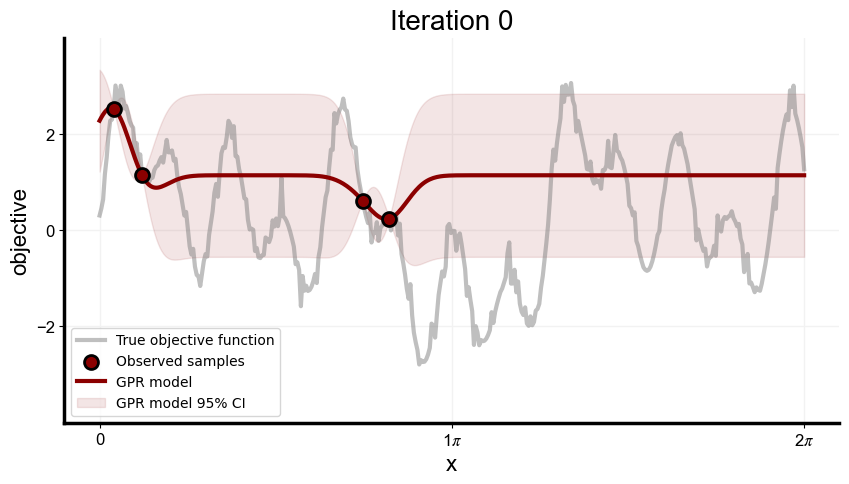

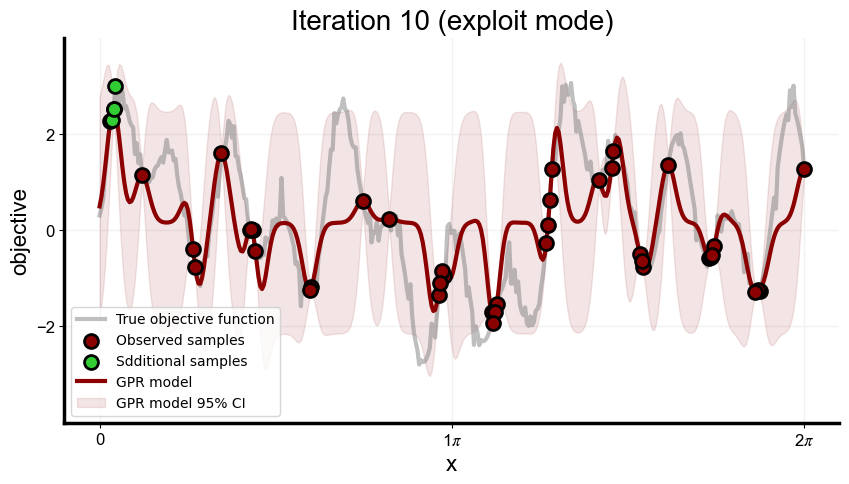

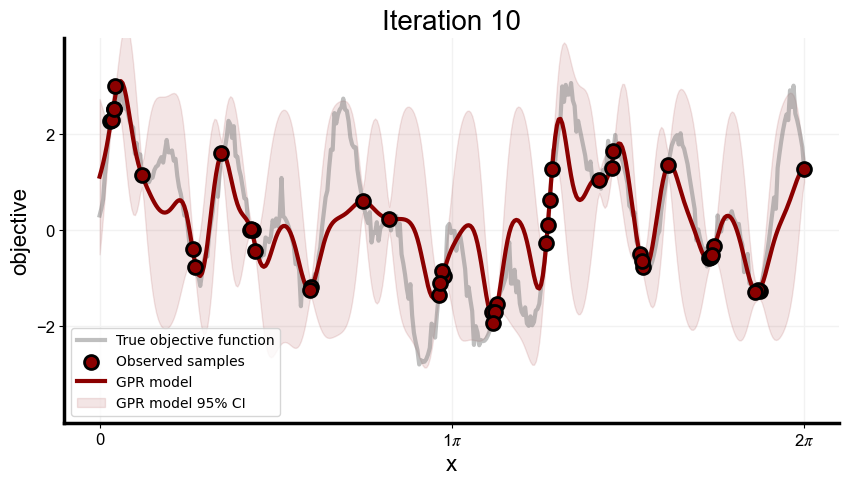

In [7]:
indices = np.indices(x.shape)[0]
seed_indices = np.random.choice(indices, size=4)
seed_x, seed_y = x[seed_indices], y[seed_indices]

bayes_opt(x, y, seed_x, seed_y, 4, "balance")
all_images = gather_images("suggested_samples/", "updated_gp/")
print(all_images)
make_gif(all_images, length=10)

# Descriptors with Songbird

In [8]:
# get Descriptors for Lewis acids and prepare for analyzing FI
feature_importance_objective = "sn2"
d = Descriptors(FI_obj=feature_importance_objective)
d.gen_hess = False
d.get_descriptors()
# add complexation energy descriptor
d_m_dict = pd.read_csv("comp_chem/summary_09_28_2022.csv", index_col=0).to_dict(orient="index")
energies = json.load(open("comp_chem/best_energies.json", "rb"))
names_dict = json.load(open("xyz_files/formula_to_name.json", "rb"))
new_dict = {}
for key, value in energies.items():
    if key == "boron_trifluoride":
        key = "boron_trifluoride_etherate"
    elif key == "copper_ii_flouride":
        key = "copper_ii_fluoride"
    elif key == "lithium_tetrafluroborate":
        key = "lithium_tetrafluoroborate"
    try:
        d.descriptors[names_dict[key]].append(value)
    except:
        pass
d.keys.append("complexation_energy")
# create DataFrame for Feature Importance and PCA
d.sub_descriptors()


generating descriptors...


	gathering MORFEUS descriptors...
	failed to gather xTB descriptors...
	gathering LFCs...

	gathering MORFEUS descriptors...
	failed to gather xTB descriptors...
	gathering LFCs...

	gathering MORFEUS descriptors...
	failed to gather xTB descriptors...
	gathering LFCs...

	gathering MORFEUS descriptors...
	failed to gather xTB descriptors...
	gathering LFCs...

	gathering MORFEUS descriptors...
	failed to gather xTB descriptors...
	gathering LFCs...

	gathering MORFEUS descriptors...
	failed to gather xTB descriptors...
	gathering LFCs...

	gathering MORFEUS descriptors...
	failed to gather xTB descriptors...
	gathering LFCs...

	gathering MORFEUS descriptors...
	failed to gather xTB descriptors...
	gathering LFCs...

	gathering MORFEUS descriptors...
	failed to gather xTB descriptors...
	gathering LFCs...

	gathering MORFEUS descriptors...
	failed to gather xTB descriptors...
	gathering LFCs...

	gathering MORFEUS descriptors...
	failed to gather xTB descr

# Principal Component Analysis

In [9]:
# define pandas DataFrame with Descriptor representation of LAs
columns = d.keys
df = pd.DataFrame.from_dict(d.descriptors, orient="index", columns=columns).dropna()
# use a StandardScaler to transform the Descriptors for PCA
df[df.columns] = StandardScaler().fit_transform(df[df.columns])
# fit PCA
pca = PCA(n_components=2)
pcas = pca.fit_transform(df)
pca_df = pd.DataFrame(pcas, columns = ["PC 1", "PC 2"])

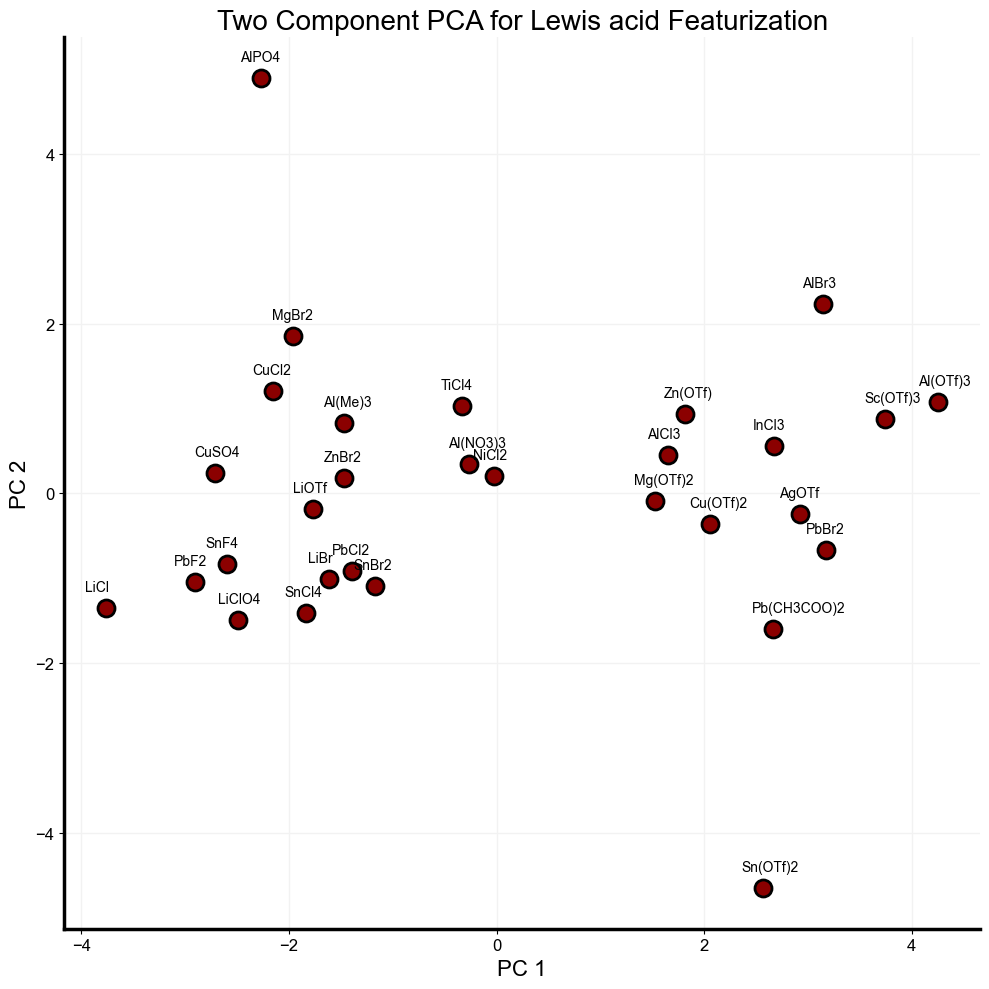

In [10]:
# generate figure
fd_medium = {"name": "Arial", "size": 16}
fd_large = {"name": "Arial", "size": 20}
fig, ax = gen_single_figure(size = (10, 10))
# get top two features for each PC
pc_1_ifs = [columns[i] for i in abs(pca.components_).argsort()[0][-2:]]
pc_2_ifs = [columns[i] for i in abs(pca.components_).argsort()[1][-2:]]
# plot pcs
plt.scatter(pca_df["PC 1"], pca_df["PC 2"], c = "darkred", edgecolor = "black", linewidth = 2, s = 150)
plt.title("Two Component PCA for Lewis acid Featurization", fontdict=fd_large)
plt.xlabel(f"PC 1", fontdict=fd_medium)
plt.ylabel(f"PC 2", fontdict=fd_medium)
plt.xticks([-4, -2, 0, 2, 4])
plt.yticks([-4, -2, 0, 2, 4])
for i, key in enumerate(list(df.index)):
    plt.annotate(key, (pca_df["PC 1"][i]-0.20, pca_df["PC 2"][i]+0.20), fontsize=10, font="Arial")
plt.tight_layout()
fig.savefig("PCA.png")

In [11]:
# get contribution to PCs
pc_1_indices = abs(pca.components_).argsort()[0,-2:]
pc_1_values = abs(pca.components_)[0][pc_1_indices] / sum(abs(pca.components_)[0])
pc_1_names = pc_1_ifs
pc_2_indices = abs(pca.components_).argsort()[1,-2:]
pc_2_values = abs(pca.components_)[1][pc_2_indices] / sum(abs(pca.components_)[1])
pc_2_names = pc_2_ifs
pc_1_values, pc_1_names, pc_2_values, pc_2_names

(array([0.14488641, 0.14909545]),
 ['sasa_volume', 'disp_volume'],
 array([0.21690844, 0.22777406]),
 ['oxygen_to_CH2', 'oxygen_to_CH'])

# Feature Importance with RFR

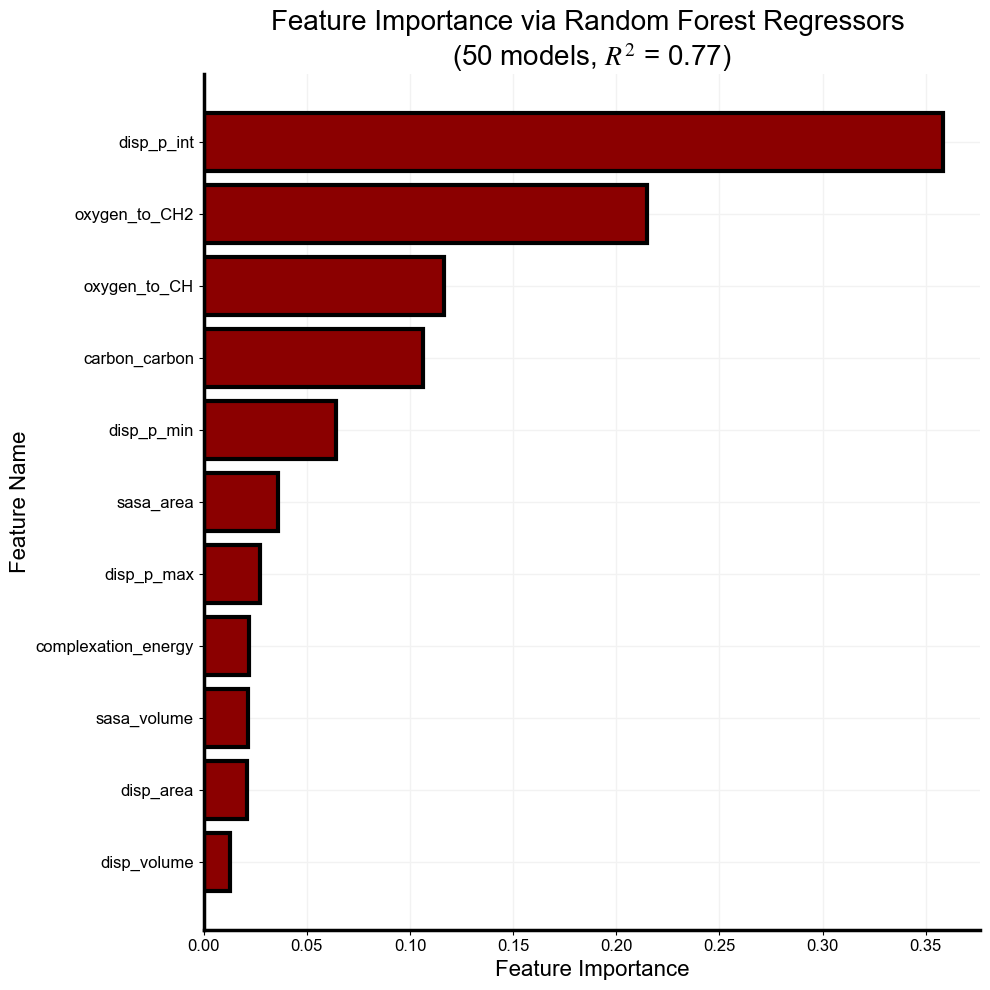

In [12]:
# generate single figure
fig, ax = gen_single_figure(size = (10, 10))
# train 50 RFRs and track important features
n_models = 50
d.trim_descriptors(n_models=n_models)
labels = np.asarray(list(d.importances_dict.keys()))
fis = np.asarray(list(d.importances_dict.values()))
sorted = fis.argsort()
sorted_labels = labels[sorted]
sorted_fis = fis[sorted]
# plot FI
plt.title(f"Feature Importance via Random Forest Regressors \n({n_models} models, $R^2$ = {np.round(np.average(d.train_scores), 3)})", fontdict = fd_large)
plt.xlabel(f"Feature Importance", fontdict = fd_medium)
plt.ylabel("Feature Name", fontdict = fd_medium)
plt.barh(sorted_labels, sorted_fis, color="darkred", edgecolor="black", linewidth=3.0)

plt.tight_layout()
fig.savefig("FI.png")

# Evaluation of Complexation and Dimerization Energies

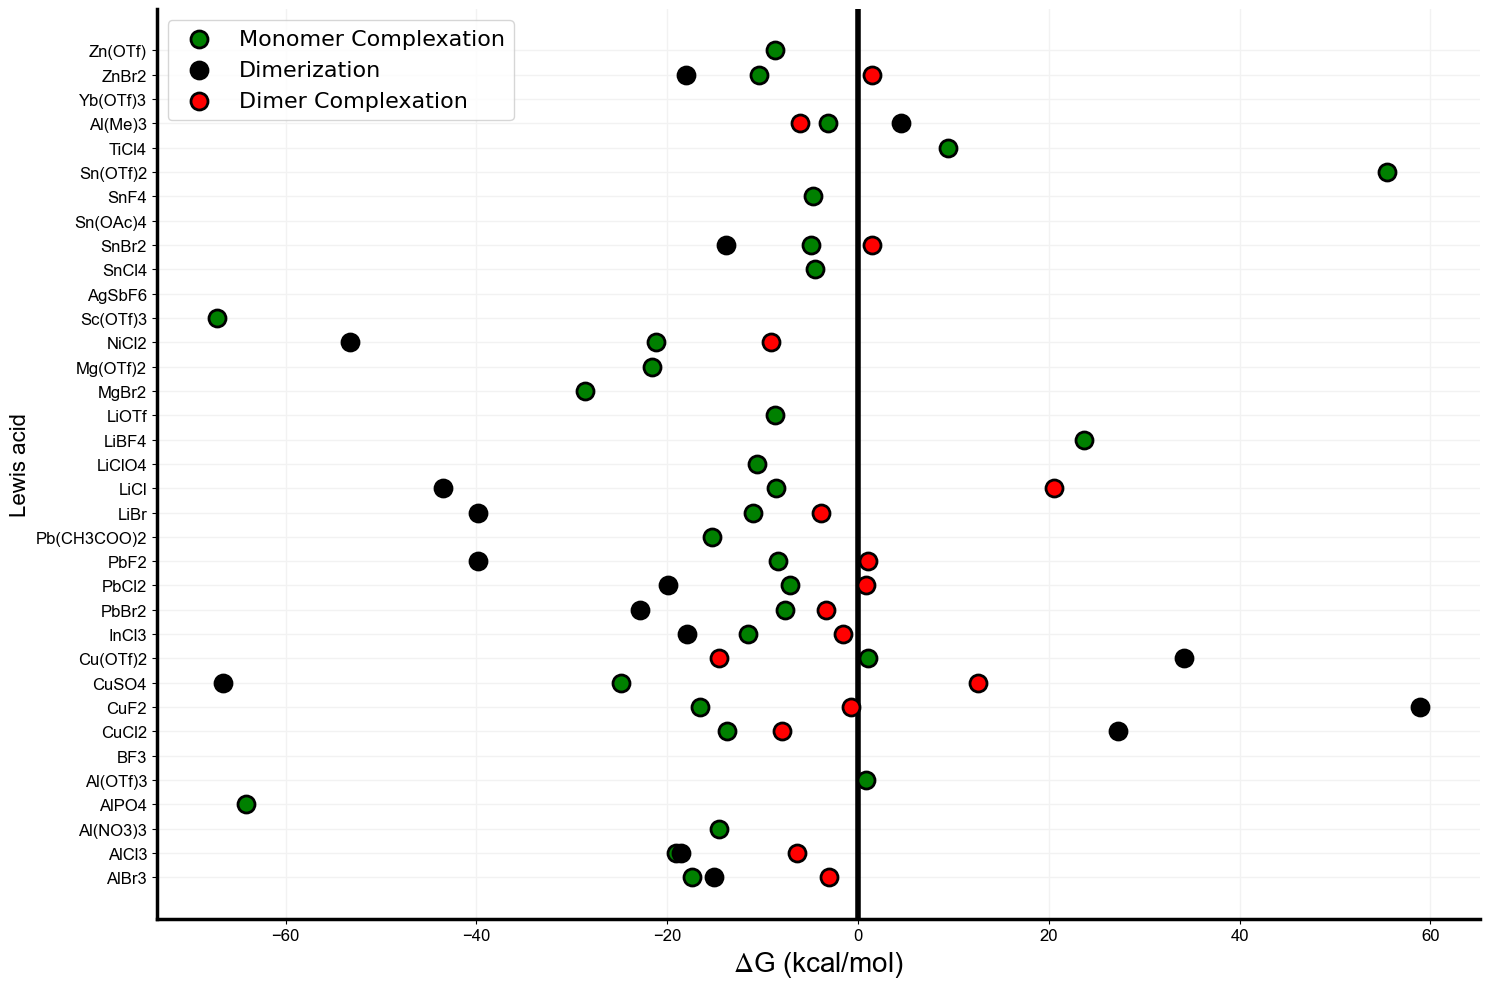

In [13]:
# load computational data and correct some annoying typos
d_m_dict = pd.read_csv("comp_chem/summary_09_28_2022.csv", index_col=0).drop("silver_trifluoromethanesulfonate").to_dict(orient="index")
names_dict = json.load(open("xyz_files/formula_to_name.json", "rb"))
names, dimerization, m, d = [], [], [], []
for key, value in d_m_dict.items():
    if key == "boron_trifluoride":
        key = "boron_trifluoride_etherate"
    elif key == "copper_ii_flouride":
        key = "copper_ii_fluoride"
    elif key == "lithium_tetrafluroborate":
        key = "lithium_tetrafluoroborate"
    try:
        names.append(names_dict[key])
        dimerization.append(value["dimerization"])
        m.append(value["monomer_complexation"])
        d.append(value["dimer_complexation"])
    except:
        pass
# generate single figure
fig, ax = gen_single_figure(size = (15, 10))
# plot data
plt.scatter(m, names, edgecolor = "black", c = "green", linewidth = 2, s = 150, marker="o", label="Monomer Complexation",zorder = 3)
plt.scatter(dimerization, names, edgecolor = "black", c = "black", linewidth = 2, s = 150, marker="o", label="Dimerization", zorder = 4)
plt.scatter(d, names, edgecolor = "black", c = "red", linewidth = 2, s = 150, marker="o", label="Dimer Complexation", zorder = 2)
plt.axvline(x = 0, color = "black", linestyle = '-', linewidth = 4, zorder=1)
plt.legend(loc = "upper left", fontsize = 16)
#plt.title("Lewis acid\nDimerization and Complexation Energies", fontdict=fd_large)
plt.ylabel("Lewis acid", fontdict=fd_medium)
plt.xlabel("$\Delta$G (kcal/mol)", fontdict=fd_large)

plt.tight_layout()
fig.savefig("dimerization_complexation.png")
